# Matching truth to reco for tracks #

Plots investigating the truth to reco matches for the tracks

Nicole Hartman
June 2017


In [2]:
filepath  = '/atlas/local/BtagOptimizationNtuples/user.giacinto.mc16_13TeV.410501.PowhegPythia8EvtGen_A14_ttbar_hdamp258p75.BTagNtuples.May22.JetFitterStudies.v02_Akt4EMTo/user.giacinto.11401650.Akt4EMTo._000001.root'

In [3]:
import numpy as np
import pandas as pd

# matplotlib includes
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color map palatte
#matplotlib.rcParams.update({'font.size': 16})
from matplotlib.colors import LogNorm

# rootpy functions
from rootpy.vector import LorentzVector,Vector3
from rootpy.plotting import Hist,Hist2D
import rootpy.plotting.root2matplotlib as rplt

# useful functions that I've used in different notebooks stored in a single module
from dataHandling import root2pandas, flatten, flatten_trks
from prettyPlots  import plot_1D, plot_2D

In [4]:
df = root2pandas(filepath, 'bTag_AntiKt4EMTopoJets')

# Looking at the reco / truth particle matches#

(1) How many reco tracks are matched to truth tracks from the vertex 
    
    The branch jet_trk_jf_Vertex stores the INDEX of the vertex (from the intersections of the reco tracks with the bH flight path) that the track has a truth match to.

(What I thought this morning:
How I'm interpretting statement (1): How many reco / selected tracks are truth matched to coming from a vertex.   
So I think you could find this quantity by, for each jet, counting the number of tracks from a vertex with the same number.)

(2) How many other particles aren't matched to the vertex

# Looking at the tracks from JF

(3) In the collection of tracks from JF

    (a) How many tracks from the B+C cascade do we actually keep
        => The truth info should be in the bH_nChild
        
    (b) How many tracks from fragmentation + GEANT do we wrongly incorporate
    
    (c) How many track from the B+C decay do we lose
        (I wrote before that we might want to look up the track_to_vertex associators)

Next: Loop through all of the tracks, and select the ones that are included by JetFitter.

In [5]:
# Make histograms to store these quantities
nbins = 11
hmin  = -0.5
hmax  = nbins - hmin 

# The histograms are grouped in the order that I'm plotting them

h_ntrks_recoMatchedToTruth = Hist(nbins+4,hmin,hmax+4) # reco tracks matched to truth
h_ntrks_notFromCascade     = Hist(21,0,21) # tracks not from B-Cascade
h_p_notFromCascade = Hist(20,0,8) # momentum of tracks not truth matched to the B-Cascade

h_ntrks_JF    = Hist(nbins,hmin,hmax)  # Number of tracks from JF 
h_ntrks_KEPT  = Hist(nbins,hmin,hmax)  # Number of truth tracks JF also finds
h_ntrks_PU    = Hist(nbins,hmin,hmax)  # Number of trks from PU
h_ntrks_FRAG  = Hist(nbins,hmin,hmax)  # Number of trks from fragmentation 
h_ntrks_GEANT = Hist(nbins,hmin,hmax)  # Number of trks from detector affects

h_ntrks_LOST     = Hist(nbins,hmin,hmax) # Number of truth trks not reconstructed
h_ntrks_LOST_JF  = Hist(nbins,hmin,hmax) # Number of truth trks that JF fails to discover
h_RECOtrks_LOST_JF  = Hist(nbins,hmin,hmax) # reco tracks lost by JF

h_LOSTtrks_pT    = Hist(20,0,8) # pT of truth tracks not in reco [MeV]
h_LOSTtrks_pT_JF = Hist(20,0,8) # pT of truth tracks not in JF

h_ntrks_vs_jpt = Hist2D(25,0,125, 31,-0.5,30.5) # # of reco trks vs. b-jet pT


In [23]:
# The first for loop iterates over the events
n_print = 1
orig = ["PU","b-had",'c-had','frag','GEANT']

# Count the # of trks barcode matched to truth IDed as PU
nPUtrksBarcodeMatched = 0
ntrksBarcodeMatched   = 0

for (_,(evt_algs,evt_trkBarcodes,evt_trkPDGs,evt_trkPt,evt_trkEta,evt_trkPhi,evt_trkOrigs,evt_childBarcodes,evt_childPDGs,evt_childPxs,evt_childPys,evt_childPzs,evt_jet_flav,evt_jet_pt)) in df[['jet_trk_algo','jet_trk_barcode','jet_trk_pdg_id','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_orig','jet_bH_child_barcode','jet_bH_child_pdg_id','jet_bH_child_px','jet_bH_child_py','jet_bH_child_pz','jet_LabDr_HadF','jet_pt']].iterrows():

    # This loops over the jets in the evt
    for algs,trkBarcodes,trkPDGs,trkPts,trkEtas,trkPhis,trkOrigs,childBarcodes,childPDGs,childPxs,childPys,childPzs,jet_flav,jet_pt in zip(evt_algs,evt_trkBarcodes,evt_trkPDGs,evt_trkPt,evt_trkEta,evt_trkPhi,evt_trkOrigs,evt_childBarcodes,evt_childPDGs,evt_childPxs,evt_childPys,evt_childPzs,evt_jet_flav,evt_jet_pt):

        # Only look at the particles that have an associated b-hadron
        if jet_flav != 5:
            continue
        
        # Clear the variables / jet info that you have
        ntrks_recoMatchedToTruth = 0
        
        ntrks_notFromCascade = 0
        
        ntrks_JF    = 0  # Number of tracks from JF
        ntrks_KEPT  = 0  # truth tracks JF also finds
        ntrks_PU    = 0  # Number of JF trks from PU
        ntrks_FRAG  = 0  # Number of JF trks from fragmentation 
        ntrks_GEANT = 0  # Number of JF trks from detector affects
        
        ntrks_LOST    = 0  # Number of truth trks not reconstructed
        ntrks_LOST_JF = 0  # Number of truth trks that JF fails to discover
        
        nRECOtrks_LOST_JF = 0
        
        # Define a new variable / list to test if the JF track has a truth match
        trkBarcodes_JF = [ trkBarcode if (alg>=16) else -1 for alg,trkBarcode in zip(algs,trkBarcodes) ]
            
        # Loop through the truth p'cles to find the reco matches before
        # selecting just the JF tracks.
        for childBarcode,childPDG,childPx,childPy,childPz in zip(childBarcodes,childPDGs,childPxs,childPys,childPzs):
            
            # if a barcode isn't in the reco barcodes, it cannot be in the JF barcodes
            if childBarcode not in trkBarcodes:
                ntrks_LOST = ntrks_LOST + 1
                h_LOSTtrks_pT.Fill(0.001*np.sqrt(childPx**2 + childPy**2))
                
            if childBarcode not in trkBarcodes_JF:
                ntrks_LOST_JF = ntrks_LOST_JF + 1
                h_LOSTtrks_pT_JF.Fill(0.001*np.sqrt(childPx**2 + childPy**2))
          
                   
        # Loop through the reco tracks
        for alg,trkBarcode,trkPDG,trkPt,trkEta,trkPhi,trkOrig in zip(algs,trkBarcodes,trkPDGs,trkPts,trkEtas,trkPhis,trkOrigs): 

            # Check if this reco track has a truth match
            if trkBarcode in childBarcodes:
                ntrks_recoMatchedToTruth = ntrks_recoMatchedToTruth + 1
               
            
                # Look at if this track from the b/c-cascade "vetex" was found by JF
                if alg < 16:
                    nRECOtrks_LOST_JF = nRECOtrks_LOST_JF +1
                
                if trkOrig == -1: #not (trkOrig == 0 or trkOrig == 1):
                    
                    # find the index in the child's list for which these values are =
                    i = np.where(childBarcodes == trkBarcode)
                    print "\ntrkOrig = {0}, trkPDG = {1}, trkBarcode = {2}, childPDG = {3}, childBarcode = {4}".format(trkOrig,trkPDG,trkBarcode,childPDGs[i][0],childBarcodes[i][0])
                    
                    # Print out the momentum and direction for the children and the tracks
                    print "trk_momentum:   pt = {0:2.2f} [GeV], eta = {1:2.2f}, phi = {2:2.2f}".format(trkPt/1000.,trkEta,trkPhi)
                    
                    child_momentum = Vector3(childPxs[i][0],childPys[i][0],childPzs[i][0])
                    print "child momentum: pt = {0:2.2f} [GeV], eta = {1:2.2f}, phi = {2:2.2f}".format(child_momentum.Pt()/1000.,child_momentum.Eta(),child_momentum.Phi())

                    nPUtrksBarcodeMatched = nPUtrksBarcodeMatched + 1
                    
            # now look at the number of tracks that have been truth matched to this vertex that weren't found by JF
            else:
                ntrks_notFromCascade = ntrks_notFromCascade + 1
                trk_pVect = Vector3()
                trk_pVect.SetPtEtaPhi(trkPt,trkEta,trkPhi)
                h_p_notFromCascade.Fill(trk_pVect.Mag() / 1000.)
            
            
            # Now only look at JF tracks
            if alg < 16:
                #nRECOtrks_LOST_JF = nRECOtrks_LOST_JF +1
                continue
             
            ntrks_JF = ntrks_JF + 1
            
            # Look at the contributions of non-heavy-flavor tracks in JF 
            if(trkOrig == -1):
                ntrks_PU = ntrks_PU + 1
            if(trkOrig == 2): 
                ntrks_FRAG = ntrks_FRAG + 1
            elif(trkOrig == 3):
                ntrks_GEANT = ntrks_GEANT + 1
            
            if _ < n_print:
                print "This trk from {0:5s} w/ pdg {1:4d} is from JF!".format(orig[trkOrig],trkPDG)
                                     
        # Fill the histograms
        h_ntrks_recoMatchedToTruth.Fill(ntrks_recoMatchedToTruth)
        ntrksBarcodeMatched = ntrksBarcodeMatched + ntrks_recoMatchedToTruth
        
        h_ntrks_notFromCascade.Fill(ntrks_notFromCascade)
        
        h_ntrks_JF.Fill(ntrks_JF)
        h_ntrks_KEPT.Fill(len(childBarcodes) - ntrks_LOST_JF)
        h_ntrks_PU.Fill(ntrks_PU)
        h_ntrks_FRAG.Fill(ntrks_FRAG)
        h_ntrks_GEANT.Fill(ntrks_GEANT)

        h_ntrks_LOST.Fill(ntrks_LOST)
        h_ntrks_LOST_JF.Fill(ntrks_LOST_JF)
        h_RECOtrks_LOST_JF.Fill(nRECOtrks_LOST_JF)

        h_ntrks_vs_jpt.Fill(jet_pt/1000. , trkPDGs.size)
 

This trk from PU    w/ pdg  211 is from JF!
This trk from b-had w/ pdg -211 is from JF!
This trk from b-had w/ pdg  211 is from JF!

trkOrig = -1, trkPDG = -3222, trkBarcode = 10029, childPDG = -3222, childBarcode = 10029
trk_momentum:   pt = 8.07 [GeV], eta = -1.03, phi = -0.69
child momentum: pt = 17.02 [GeV], eta = -1.03, phi = -0.70

trkOrig = -1, trkPDG = -321, trkBarcode = 10006, childPDG = -321, childBarcode = 10006
trk_momentum:   pt = 47.83 [GeV], eta = 1.40, phi = -1.34
child momentum: pt = 38.52 [GeV], eta = 1.40, phi = -1.34

trkOrig = -1, trkPDG = 11, trkBarcode = 10027, childPDG = 11, childBarcode = 10027
trk_momentum:   pt = 21.17 [GeV], eta = 1.64, phi = 1.68
child momentum: pt = 13.35 [GeV], eta = 1.64, phi = 1.68

trkOrig = -1, trkPDG = -211, trkBarcode = 10022, childPDG = -211, childBarcode = 10022
trk_momentum:   pt = 0.46 [GeV], eta = -0.13, phi = 1.24
child momentum: pt = 0.42 [GeV], eta = -0.12, phi = 1.24

trkOrig = -1, trkPDG = -211, trkBarcode = 10023, childPD

child momentum: pt = 2.85 [GeV], eta = 1.21, phi = 0.91

trkOrig = -1, trkPDG = 321, trkBarcode = 10034, childPDG = 321, childBarcode = 10034
trk_momentum:   pt = 4.60 [GeV], eta = -1.39, phi = -0.42
child momentum: pt = 4.63 [GeV], eta = -1.39, phi = -0.42

trkOrig = -1, trkPDG = 211, trkBarcode = 10038, childPDG = 211, childBarcode = 10038
trk_momentum:   pt = 1.55 [GeV], eta = -1.40, phi = -0.37
child momentum: pt = 3.15 [GeV], eta = -1.41, phi = -0.39

trkOrig = -1, trkPDG = 11, trkBarcode = 10034, childPDG = 11, childBarcode = 10034
trk_momentum:   pt = 0.58 [GeV], eta = 2.54, phi = -1.38
child momentum: pt = 2.32 [GeV], eta = 2.54, phi = -1.34

trkOrig = -1, trkPDG = 211, trkBarcode = 10026, childPDG = 211, childBarcode = 10026
trk_momentum:   pt = 1.42 [GeV], eta = 2.30, phi = 2.62
child momentum: pt = 2.69 [GeV], eta = 2.30, phi = 2.59

trkOrig = -1, trkPDG = 211, trkBarcode = 10010, childPDG = 211, childBarcode = 10010
trk_momentum:   pt = 0.84 [GeV], eta = 1.98, phi = -2.55
c

trk_momentum:   pt = 2.45 [GeV], eta = 1.42, phi = -1.01
child momentum: pt = 10.03 [GeV], eta = 1.37, phi = -0.98

trkOrig = -1, trkPDG = -211, trkBarcode = 10059, childPDG = -211, childBarcode = 10059
trk_momentum:   pt = 33.79 [GeV], eta = -1.03, phi = 0.95
child momentum: pt = 23.53 [GeV], eta = -1.03, phi = 0.95

trkOrig = -1, trkPDG = 211, trkBarcode = 10020, childPDG = 211, childBarcode = 10020
trk_momentum:   pt = 1.23 [GeV], eta = 1.49, phi = -1.24
child momentum: pt = 1.10 [GeV], eta = 1.49, phi = -1.23

trkOrig = -1, trkPDG = -211, trkBarcode = 10038, childPDG = -211, childBarcode = 10038
trk_momentum:   pt = 0.55 [GeV], eta = 2.25, phi = -1.10
child momentum: pt = 0.59 [GeV], eta = 2.26, phi = -1.09

trkOrig = -1, trkPDG = -211, trkBarcode = 10049, childPDG = -211, childBarcode = 10049
trk_momentum:   pt = 2.31 [GeV], eta = -1.69, phi = 0.96
child momentum: pt = 2.62 [GeV], eta = -1.69, phi = 0.97

trkOrig = -1, trkPDG = 211, trkBarcode = 10013, childPDG = 211, childBarcode

trkOrig = -1, trkPDG = 211, trkBarcode = 10025, childPDG = 211, childBarcode = 10025
trk_momentum:   pt = 1.76 [GeV], eta = -2.47, phi = 2.01
child momentum: pt = 18.73 [GeV], eta = -2.50, phi = 2.00

trkOrig = -1, trkPDG = -211, trkBarcode = 10033, childPDG = -211, childBarcode = 10033
trk_momentum:   pt = 3.37 [GeV], eta = -2.47, phi = 2.00
child momentum: pt = 13.91 [GeV], eta = -2.50, phi = 2.00

trkOrig = -1, trkPDG = 211, trkBarcode = 10034, childPDG = 211, childBarcode = 10034
trk_momentum:   pt = 3.64 [GeV], eta = -1.28, phi = 2.78
child momentum: pt = 3.76 [GeV], eta = -1.28, phi = 2.77

trkOrig = -1, trkPDG = -211, trkBarcode = 10039, childPDG = -211, childBarcode = 10039
trk_momentum:   pt = 2.25 [GeV], eta = 0.41, phi = -0.35
child momentum: pt = 7.39 [GeV], eta = 0.42, phi = -0.37

trkOrig = -1, trkPDG = 211, trkBarcode = 10055, childPDG = 211, childBarcode = 10055
trk_momentum:   pt = 19.51 [GeV], eta = -0.89, phi = -0.55
child momentum: pt = 9.03 [GeV], eta = -0.89, phi 


trkOrig = -1, trkPDG = 211, trkBarcode = 10060, childPDG = 211, childBarcode = 10060
trk_momentum:   pt = 0.45 [GeV], eta = -2.33, phi = -0.87
child momentum: pt = 0.43 [GeV], eta = -2.36, phi = -0.90

trkOrig = -1, trkPDG = 11, trkBarcode = 10051, childPDG = 11, childBarcode = 10051
trk_momentum:   pt = 1.61 [GeV], eta = -0.31, phi = 0.52
child momentum: pt = 1.64 [GeV], eta = -0.30, phi = 0.54

trkOrig = -1, trkPDG = 211, trkBarcode = 10052, childPDG = 211, childBarcode = 10052
trk_momentum:   pt = 2.46 [GeV], eta = -1.46, phi = -1.71
child momentum: pt = 2.46 [GeV], eta = -1.46, phi = -1.71

trkOrig = -1, trkPDG = 211, trkBarcode = 10048, childPDG = 211, childBarcode = 10048
trk_momentum:   pt = 0.67 [GeV], eta = -0.65, phi = -2.37
child momentum: pt = 6.09 [GeV], eta = -0.65, phi = -2.43

trkOrig = -1, trkPDG = 211, trkBarcode = 10039, childPDG = 211, childBarcode = 10039
trk_momentum:   pt = 0.58 [GeV], eta = -0.09, phi = 2.92
child momentum: pt = 0.53 [GeV], eta = -0.09, phi = 2

child momentum: pt = 0.72 [GeV], eta = 1.44, phi = -1.40

trkOrig = -1, trkPDG = -211, trkBarcode = 10042, childPDG = -211, childBarcode = 10042
trk_momentum:   pt = 1.61 [GeV], eta = -1.27, phi = 2.20
child momentum: pt = 1.27 [GeV], eta = -1.27, phi = 2.20

trkOrig = -1, trkPDG = 11, trkBarcode = 10021, childPDG = 11, childBarcode = 10021
trk_momentum:   pt = 2.63 [GeV], eta = 1.13, phi = -1.01
child momentum: pt = 3.40 [GeV], eta = 1.13, phi = -1.01

trkOrig = -1, trkPDG = -211, trkBarcode = 10022, childPDG = -211, childBarcode = 10022
trk_momentum:   pt = 62.03 [GeV], eta = 2.48, phi = -1.31
child momentum: pt = 36.72 [GeV], eta = 2.45, phi = -1.31

trkOrig = -1, trkPDG = 11, trkBarcode = 10014, childPDG = 11, childBarcode = 10014
trk_momentum:   pt = 8.51 [GeV], eta = 2.47, phi = -1.29
child momentum: pt = 1.55 [GeV], eta = 2.52, phi = -1.34

trkOrig = -1, trkPDG = -3222, trkBarcode = 10020, childPDG = -3222, childBarcode = 10020
trk_momentum:   pt = 580.44 [GeV], eta = 0.25, phi 

trk_momentum:   pt = 2.06 [GeV], eta = 1.65, phi = 1.07
child momentum: pt = 1.61 [GeV], eta = 1.65, phi = 1.07

trkOrig = -1, trkPDG = 211, trkBarcode = 10013, childPDG = 211, childBarcode = 10013
trk_momentum:   pt = 8.74 [GeV], eta = -0.17, phi = 0.53
child momentum: pt = 9.58 [GeV], eta = -0.17, phi = 0.53

trkOrig = -1, trkPDG = 211, trkBarcode = 10019, childPDG = 211, childBarcode = 10019
trk_momentum:   pt = 61.38 [GeV], eta = -1.11, phi = 0.13
child momentum: pt = 52.31 [GeV], eta = -1.11, phi = 0.13

trkOrig = -1, trkPDG = 211, trkBarcode = 10124, childPDG = 211, childBarcode = 10124
trk_momentum:   pt = 0.42 [GeV], eta = 2.39, phi = -1.08
child momentum: pt = 0.39 [GeV], eta = 2.37, phi = -1.10

trkOrig = -1, trkPDG = -3222, trkBarcode = 10052, childPDG = -3222, childBarcode = 10052
trk_momentum:   pt = 871.30 [GeV], eta = -0.41, phi = -1.30
child momentum: pt = 24.16 [GeV], eta = -0.41, phi = -1.30

trkOrig = -1, trkPDG = 211, trkBarcode = 10030, childPDG = 211, childBarcode

trkOrig = -1, trkPDG = 211, trkBarcode = 10050, childPDG = 211, childBarcode = 10050
trk_momentum:   pt = 0.81 [GeV], eta = -2.47, phi = 0.56
child momentum: pt = 2.18 [GeV], eta = -2.46, phi = 0.50

trkOrig = -1, trkPDG = 211, trkBarcode = 10012, childPDG = 211, childBarcode = 10012
trk_momentum:   pt = 0.50 [GeV], eta = 1.70, phi = 2.02
child momentum: pt = 0.56 [GeV], eta = 1.70, phi = 2.02

trkOrig = -1, trkPDG = -211, trkBarcode = 10065, childPDG = -211, childBarcode = 10065
trk_momentum:   pt = 0.85 [GeV], eta = 2.36, phi = -0.22
child momentum: pt = 1.29 [GeV], eta = 2.36, phi = -0.21

trkOrig = -1, trkPDG = 211, trkBarcode = 10050, childPDG = 211, childBarcode = 10050
trk_momentum:   pt = 0.48 [GeV], eta = -1.49, phi = -1.49
child momentum: pt = 0.50 [GeV], eta = -1.50, phi = -1.49

trkOrig = -1, trkPDG = -211, trkBarcode = 10034, childPDG = -211, childBarcode = 10034
trk_momentum:   pt = 0.52 [GeV], eta = -1.46, phi = -1.62
child momentum: pt = 0.49 [GeV], eta = -1.46, phi = -

trk_momentum:   pt = 0.81 [GeV], eta = -1.87, phi = -2.25
child momentum: pt = 0.82 [GeV], eta = -1.87, phi = -2.26

trkOrig = -1, trkPDG = -211, trkBarcode = 10054, childPDG = -211, childBarcode = 10054
trk_momentum:   pt = 0.64 [GeV], eta = -1.18, phi = -2.42
child momentum: pt = 0.69 [GeV], eta = -1.17, phi = -2.42

trkOrig = -1, trkPDG = -321, trkBarcode = 10044, childPDG = -321, childBarcode = 10044
trk_momentum:   pt = 1.49 [GeV], eta = 0.02, phi = -0.51
child momentum: pt = 27.29 [GeV], eta = 0.01, phi = -0.55

trkOrig = -1, trkPDG = -321, trkBarcode = 10025, childPDG = -321, childBarcode = 10025
trk_momentum:   pt = 1.66 [GeV], eta = 0.24, phi = 0.66
child momentum: pt = 2.30 [GeV], eta = 0.24, phi = 0.66

trkOrig = -1, trkPDG = -211, trkBarcode = 10007, childPDG = -211, childBarcode = 10007
trk_momentum:   pt = 11.01 [GeV], eta = 2.43, phi = 2.61
child momentum: pt = 16.37 [GeV], eta = 2.43, phi = 2.61

trkOrig = -1, trkPDG = 211, trkBarcode = 10023, childPDG = 211, childBarco

trk_momentum:   pt = 2.32 [GeV], eta = 1.09, phi = 1.38
child momentum: pt = 2.46 [GeV], eta = 1.10, phi = 1.38

trkOrig = -1, trkPDG = -321, trkBarcode = 10013, childPDG = -321, childBarcode = 10013
trk_momentum:   pt = 9.99 [GeV], eta = -0.54, phi = 1.85
child momentum: pt = 19.23 [GeV], eta = -0.36, phi = 1.86

trkOrig = -1, trkPDG = 321, trkBarcode = 10030, childPDG = 321, childBarcode = 10030
trk_momentum:   pt = 9.38 [GeV], eta = -0.42, phi = -0.08
child momentum: pt = 10.05 [GeV], eta = -0.42, phi = -0.08

trkOrig = -1, trkPDG = 321, trkBarcode = 10046, childPDG = 321, childBarcode = 10046
trk_momentum:   pt = 3.82 [GeV], eta = -1.30, phi = -1.42
child momentum: pt = 9.18 [GeV], eta = -1.29, phi = -1.43

trkOrig = -1, trkPDG = 321, trkBarcode = 10034, childPDG = 321, childBarcode = 10034
trk_momentum:   pt = 13.16 [GeV], eta = -1.57, phi = -1.50
child momentum: pt = 11.99 [GeV], eta = -1.57, phi = -1.50

trkOrig = -1, trkPDG = 211, trkBarcode = 10074, childPDG = 211, childBarcod

trk_momentum:   pt = 1.27 [GeV], eta = 2.52, phi = -1.12
child momentum: pt = 58.88 [GeV], eta = 2.52, phi = -1.16

trkOrig = -1, trkPDG = 211, trkBarcode = 10032, childPDG = 211, childBarcode = 10032
trk_momentum:   pt = 0.82 [GeV], eta = 2.52, phi = -1.14
child momentum: pt = 4.84 [GeV], eta = 2.52, phi = -1.17

trkOrig = -1, trkPDG = 11, trkBarcode = 10074, childPDG = 11, childBarcode = 10074
trk_momentum:   pt = 0.72 [GeV], eta = 1.56, phi = -1.61
child momentum: pt = 0.95 [GeV], eta = 1.56, phi = -1.60

trkOrig = -1, trkPDG = -211, trkBarcode = 10044, childPDG = -211, childBarcode = 10044
trk_momentum:   pt = 26.66 [GeV], eta = 2.56, phi = 0.48
child momentum: pt = 7.41 [GeV], eta = 2.56, phi = 0.48

trkOrig = -1, trkPDG = -211, trkBarcode = 10066, childPDG = -211, childBarcode = 10066
trk_momentum:   pt = 0.97 [GeV], eta = -0.91, phi = 1.09
child momentum: pt = 1.26 [GeV], eta = -0.90, phi = 1.10

trkOrig = -1, trkPDG = 211, trkBarcode = 10030, childPDG = 211, childBarcode = 1003

child momentum: pt = 0.55 [GeV], eta = -1.95, phi = 2.97

trkOrig = -1, trkPDG = -211, trkBarcode = 10122, childPDG = -211, childBarcode = 10122
trk_momentum:   pt = 13.94 [GeV], eta = -2.27, phi = 2.63
child momentum: pt = 16.12 [GeV], eta = -2.27, phi = 2.62

trkOrig = -1, trkPDG = -11, trkBarcode = 10015, childPDG = -11, childBarcode = 10015
trk_momentum:   pt = 1.72 [GeV], eta = -1.48, phi = -2.85
child momentum: pt = 7.67 [GeV], eta = -1.48, phi = -2.80

trkOrig = -1, trkPDG = 211, trkBarcode = 10045, childPDG = 211, childBarcode = 10045
trk_momentum:   pt = 2.67 [GeV], eta = 1.20, phi = -1.58
child momentum: pt = 2.86 [GeV], eta = 1.20, phi = -1.58

trkOrig = -1, trkPDG = -321, trkBarcode = 10036, childPDG = -321, childBarcode = 10036
trk_momentum:   pt = 13.76 [GeV], eta = 1.48, phi = -0.20
child momentum: pt = 9.62 [GeV], eta = 1.48, phi = -0.20

trkOrig = -1, trkPDG = -11, trkBarcode = 10010, childPDG = -11, childBarcode = 10010
trk_momentum:   pt = 0.66 [GeV], eta = 1.56, phi

child momentum: pt = 0.61 [GeV], eta = 0.07, phi = -3.08

trkOrig = -1, trkPDG = 211, trkBarcode = 10017, childPDG = 211, childBarcode = 10017
trk_momentum:   pt = 0.51 [GeV], eta = 1.25, phi = -2.45
child momentum: pt = 0.57 [GeV], eta = 1.25, phi = -2.47

trkOrig = -1, trkPDG = -211, trkBarcode = 10045, childPDG = -211, childBarcode = 10045
trk_momentum:   pt = 2.49 [GeV], eta = -1.26, phi = -1.33
child momentum: pt = 2.63 [GeV], eta = -1.26, phi = -1.32

trkOrig = -1, trkPDG = -211, trkBarcode = 10012, childPDG = -211, childBarcode = 10012
trk_momentum:   pt = 0.80 [GeV], eta = 1.89, phi = 0.81
child momentum: pt = 2.30 [GeV], eta = 1.89, phi = 0.83

trkOrig = -1, trkPDG = 211, trkBarcode = 10031, childPDG = 211, childBarcode = 10031
trk_momentum:   pt = 3.03 [GeV], eta = 0.24, phi = 2.63
child momentum: pt = 2.44 [GeV], eta = 0.24, phi = 2.63

trkOrig = -1, trkPDG = 211, trkBarcode = 10039, childPDG = 211, childBarcode = 10039
trk_momentum:   pt = 0.57 [GeV], eta = -0.09, phi = -2.

trk_momentum:   pt = 2.74 [GeV], eta = -0.19, phi = -2.86
child momentum: pt = 4.94 [GeV], eta = -0.17, phi = -2.78

trkOrig = -1, trkPDG = -211, trkBarcode = 10027, childPDG = -211, childBarcode = 10027
trk_momentum:   pt = 3.46 [GeV], eta = -2.26, phi = 0.71
child momentum: pt = 4.36 [GeV], eta = -2.26, phi = 0.70

trkOrig = -1, trkPDG = -11, trkBarcode = 10045, childPDG = -11, childBarcode = 10045
trk_momentum:   pt = 8.99 [GeV], eta = 1.22, phi = -2.37
child momentum: pt = 19.49 [GeV], eta = 1.23, phi = -2.37

trkOrig = -1, trkPDG = -211, trkBarcode = 10059, childPDG = -211, childBarcode = 10059
trk_momentum:   pt = 1.03 [GeV], eta = -0.74, phi = 0.88
child momentum: pt = 4.84 [GeV], eta = -0.74, phi = 0.83

trkOrig = -1, trkPDG = -11, trkBarcode = 10038, childPDG = -11, childBarcode = 10038
trk_momentum:   pt = 3.12 [GeV], eta = 1.19, phi = -0.61
child momentum: pt = 3.47 [GeV], eta = 1.19, phi = -0.62

trkOrig = -1, trkPDG = 11, trkBarcode = 10026, childPDG = 11, childBarcode = 1

trk_momentum:   pt = 2.80 [GeV], eta = 0.58, phi = -2.52
child momentum: pt = 3.05 [GeV], eta = 0.58, phi = -2.53

trkOrig = -1, trkPDG = -211, trkBarcode = 10067, childPDG = -211, childBarcode = 10067
trk_momentum:   pt = 2.02 [GeV], eta = -0.24, phi = 0.05
child momentum: pt = 1.97 [GeV], eta = -0.30, phi = 0.02

trkOrig = -1, trkPDG = -321, trkBarcode = 10032, childPDG = -321, childBarcode = 10032
trk_momentum:   pt = 1.56 [GeV], eta = 0.98, phi = 1.45
child momentum: pt = 2.04 [GeV], eta = 0.98, phi = 1.46

trkOrig = -1, trkPDG = 321, trkBarcode = 10026, childPDG = 321, childBarcode = 10026
trk_momentum:   pt = 4.00 [GeV], eta = 1.91, phi = -2.23
child momentum: pt = 19.12 [GeV], eta = 1.85, phi = -2.27

trkOrig = -1, trkPDG = 211, trkBarcode = 10040, childPDG = 211, childBarcode = 10040
trk_momentum:   pt = 1.69 [GeV], eta = 0.23, phi = 0.54
child momentum: pt = 1.65 [GeV], eta = 0.23, phi = 0.54

trkOrig = -1, trkPDG = -211, trkBarcode = 10026, childPDG = -211, childBarcode = 100


trkOrig = -1, trkPDG = 211, trkBarcode = 10020, childPDG = 211, childBarcode = 10020
trk_momentum:   pt = 3.25 [GeV], eta = 1.88, phi = 0.50
child momentum: pt = 4.59 [GeV], eta = 1.88, phi = 0.50

trkOrig = -1, trkPDG = 321, trkBarcode = 10017, childPDG = 321, childBarcode = 10017
trk_momentum:   pt = 10.23 [GeV], eta = 1.36, phi = 1.19
child momentum: pt = 17.99 [GeV], eta = 1.36, phi = 1.19

trkOrig = -1, trkPDG = -211, trkBarcode = 10035, childPDG = -211, childBarcode = 10035
trk_momentum:   pt = 4.68 [GeV], eta = -0.69, phi = 0.58
child momentum: pt = 4.08 [GeV], eta = -0.69, phi = 0.58

trkOrig = -1, trkPDG = 321, trkBarcode = 10043, childPDG = 321, childBarcode = 10043
trk_momentum:   pt = 10.76 [GeV], eta = 1.17, phi = -0.31
child momentum: pt = 9.85 [GeV], eta = 1.17, phi = -0.31

trkOrig = -1, trkPDG = -321, trkBarcode = 10065, childPDG = -321, childBarcode = 10065
trk_momentum:   pt = 2.92 [GeV], eta = -1.62, phi = 0.72
child momentum: pt = 2.80 [GeV], eta = -1.61, phi = 0.

trkOrig = -1, trkPDG = -211, trkBarcode = 10033, childPDG = -211, childBarcode = 10033
trk_momentum:   pt = 3.41 [GeV], eta = -0.69, phi = 1.30
child momentum: pt = 3.79 [GeV], eta = -0.69, phi = 1.30

trkOrig = -1, trkPDG = 211, trkBarcode = 10014, childPDG = 211, childBarcode = 10014
trk_momentum:   pt = 0.44 [GeV], eta = -1.85, phi = -1.68
child momentum: pt = 0.47 [GeV], eta = -1.85, phi = -1.69

trkOrig = -1, trkPDG = 13, trkBarcode = 10113, childPDG = 13, childBarcode = 10113
trk_momentum:   pt = 1.62 [GeV], eta = -1.72, phi = -1.06
child momentum: pt = 1.61 [GeV], eta = -1.73, phi = -1.07

trkOrig = -1, trkPDG = -321, trkBarcode = 10104, childPDG = -321, childBarcode = 10104
trk_momentum:   pt = 1.23 [GeV], eta = -1.73, phi = -1.07
child momentum: pt = 1.20 [GeV], eta = -1.73, phi = -1.07

trkOrig = -1, trkPDG = -211, trkBarcode = 10045, childPDG = -211, childBarcode = 10045
trk_momentum:   pt = 0.53 [GeV], eta = -1.93, phi = 1.64
child momentum: pt = 0.79 [GeV], eta = -1.94, ph

trk_momentum:   pt = 2.63 [GeV], eta = 0.13, phi = -0.11
child momentum: pt = 1.98 [GeV], eta = 0.13, phi = -0.08

trkOrig = -1, trkPDG = 211, trkBarcode = 10038, childPDG = 211, childBarcode = 10038
trk_momentum:   pt = 0.65 [GeV], eta = 2.24, phi = 2.70
child momentum: pt = 1.27 [GeV], eta = 2.24, phi = 2.68

trkOrig = -1, trkPDG = -211, trkBarcode = 10024, childPDG = -211, childBarcode = 10024
trk_momentum:   pt = 4.90 [GeV], eta = -0.38, phi = -2.46
child momentum: pt = 4.52 [GeV], eta = -0.38, phi = -2.46

trkOrig = -1, trkPDG = 211, trkBarcode = 10044, childPDG = 211, childBarcode = 10044
trk_momentum:   pt = 1.54 [GeV], eta = -0.04, phi = 2.50
child momentum: pt = 1.83 [GeV], eta = 0.21, phi = 2.50

trkOrig = -1, trkPDG = 211, trkBarcode = 10072, childPDG = 211, childBarcode = 10072
trk_momentum:   pt = 1.78 [GeV], eta = 1.29, phi = 1.03
child momentum: pt = 1.61 [GeV], eta = 1.47, phi = 1.22

trkOrig = -1, trkPDG = 211, trkBarcode = 10021, childPDG = 211, childBarcode = 10021
t

child momentum: pt = 10.29 [GeV], eta = -1.44, phi = -2.04

trkOrig = -1, trkPDG = -321, trkBarcode = 10052, childPDG = -321, childBarcode = 10052
trk_momentum:   pt = 5.78 [GeV], eta = 1.13, phi = -1.23
child momentum: pt = 6.10 [GeV], eta = 1.13, phi = -1.22

trkOrig = -1, trkPDG = 11, trkBarcode = 10016, childPDG = 11, childBarcode = 10016
trk_momentum:   pt = 0.53 [GeV], eta = 0.36, phi = -0.37
child momentum: pt = 0.54 [GeV], eta = 0.36, phi = -0.36

trkOrig = -1, trkPDG = -211, trkBarcode = 10050, childPDG = -211, childBarcode = 10050
trk_momentum:   pt = 1.51 [GeV], eta = -1.78, phi = 1.26
child momentum: pt = 11.94 [GeV], eta = -1.77, phi = 1.22

trkOrig = -1, trkPDG = 211, trkBarcode = 10036, childPDG = 211, childBarcode = 10036
trk_momentum:   pt = 9.63 [GeV], eta = 1.47, phi = -2.31
child momentum: pt = 15.54 [GeV], eta = 1.47, phi = -2.32

trkOrig = -1, trkPDG = 11, trkBarcode = 10042, childPDG = 11, childBarcode = 10042
trk_momentum:   pt = 0.48 [GeV], eta = 0.46, phi = 0.

trkOrig = -1, trkPDG = 211, trkBarcode = 10028, childPDG = 211, childBarcode = 10028
trk_momentum:   pt = 0.58 [GeV], eta = -2.34, phi = -1.11
child momentum: pt = 0.49 [GeV], eta = -2.32, phi = -1.12

trkOrig = -1, trkPDG = -11, trkBarcode = 10008, childPDG = -11, childBarcode = 10008
trk_momentum:   pt = 1.91 [GeV], eta = 0.33, phi = 0.56
child momentum: pt = 4.70 [GeV], eta = 0.33, phi = 0.55

trkOrig = -1, trkPDG = -321, trkBarcode = 10047, childPDG = -321, childBarcode = 10047
trk_momentum:   pt = 23.26 [GeV], eta = 0.75, phi = 1.16
child momentum: pt = 19.71 [GeV], eta = 0.75, phi = 1.16

trkOrig = -1, trkPDG = -211, trkBarcode = 10025, childPDG = -211, childBarcode = 10025
trk_momentum:   pt = 6.35 [GeV], eta = 0.98, phi = 0.08
child momentum: pt = 7.82 [GeV], eta = 0.93, phi = 0.09

trkOrig = -1, trkPDG = -321, trkBarcode = 10008, childPDG = -321, childBarcode = 10008
trk_momentum:   pt = 0.56 [GeV], eta = 1.73, phi = 2.60
child momentum: pt = 3.40 [GeV], eta = 1.74, phi = 2.65

child momentum: pt = 12.23 [GeV], eta = -1.80, phi = -2.84

trkOrig = -1, trkPDG = -211, trkBarcode = 10023, childPDG = -211, childBarcode = 10023
trk_momentum:   pt = 0.79 [GeV], eta = 1.54, phi = 1.47
child momentum: pt = 1.27 [GeV], eta = 1.54, phi = 1.48

trkOrig = -1, trkPDG = -211, trkBarcode = 10057, childPDG = -211, childBarcode = 10057
trk_momentum:   pt = 1.13 [GeV], eta = 1.11, phi = 2.77
child momentum: pt = 0.75 [GeV], eta = 1.11, phi = 2.76

trkOrig = -1, trkPDG = 211, trkBarcode = 10010, childPDG = 211, childBarcode = 10010
trk_momentum:   pt = 0.84 [GeV], eta = 1.79, phi = -0.12
child momentum: pt = 1.07 [GeV], eta = 1.80, phi = -0.13

trkOrig = -1, trkPDG = 211, trkBarcode = 10011, childPDG = 211, childBarcode = 10011
trk_momentum:   pt = 10.11 [GeV], eta = -0.25, phi = -0.42
child momentum: pt = 10.62 [GeV], eta = -0.25, phi = -0.42

trkOrig = -1, trkPDG = -2212, trkBarcode = 10018, childPDG = -2212, childBarcode = 10018
trk_momentum:   pt = 38.47 [GeV], eta = -2.57, 

In [24]:
print "Of the {0} trks barcode matched to truth children from a cascade, {1} had origin of PU".format(ntrksBarcodeMatched,nPUtrksBarcodeMatched)

Of the 48618.0 trks barcode matched to truth children from a cascade, 1071 had origin of PU


Lessons learned:
- Most of the reco particles matched to truth come from the b/c-cascade, but occasionally they can also come from PU or fragmentation.
- This must be due to the truth level information somehow being able to sometime incorporate a PU or frag track

Plot the number of reco tracks (used by any alg) that have been matched truth p'cles from the B-cascade. This is interesting because it is the best that our track selector algorithm will be able to do.

In [7]:
# Compare w/ the actual number of truth trks in B-cascade (from earlier ipynb)
ntrk_df = df[[key for key in df.keys() if (key.startswith('jet_bH_n'))]]
ntrk_df_flat = pd.DataFrame({k: flatten_trks(c) for k, c in ntrk_df.iteritems()})
nBtrks_inclusive = [trksB+trksD for trksB,trksD in zip(ntrk_df_flat['jet_bH_nBtracks'][ntrk_df_flat['jet_bH_nBtracks']!=-99],ntrk_df_flat['jet_bH_nCtracks'][ntrk_df_flat['jet_bH_nCtracks']!=-99])]

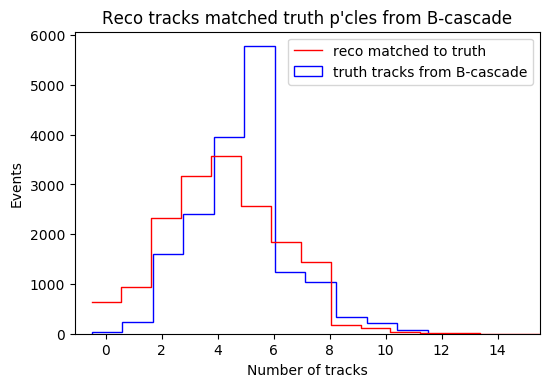

mean number of reco tracks from B-hadron: 3.9926994302


In [8]:
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
plt.hist(nBtrks_inclusive, label='truth tracks from B-cascade', bins=nbins, range=(hmin,hmax), histtype='step', color='b')
rplt.hist(h_ntrks_recoMatchedToTruth,label='reco matched to truth', color='r')
plt.xlabel('Number of tracks')
plt.ylabel('Events')
plt.legend()
plt.title('Reco tracks matched truth p\'cles from B-cascade')
plt.show()

print "mean number of reco tracks from B-hadron: {}".format(h_ntrks_recoMatchedToTruth.GetMean())

Note: I just assumed that that a reco track that was used by the algorithm was truth matched to some SV.

Sanity check: The number of reco tracks is strictly less than the number of truth trks.

Most of the reco trks have an associated truth particle, but not all.

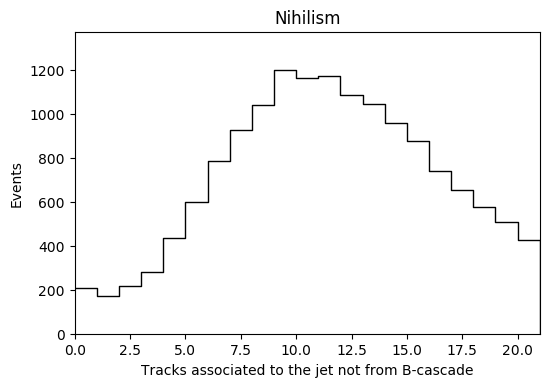

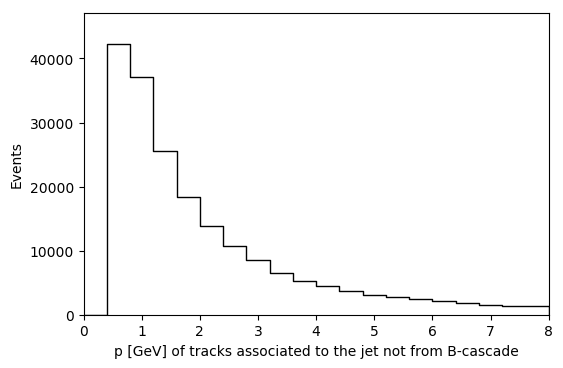

In [9]:
'''
Next: Plot the number of reco tracks that aren't matched to the vtx. in the b-cascade.
'''
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_ntrks_notFromCascade)
plt.xlabel('Tracks associated to the jet not from B-cascade')
plt.ylabel('Events')
plt.title('Nihilism')
plt.show()

fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_p_notFromCascade)
plt.xlabel('p [GeV] of tracks associated to the jet not from B-cascade')
plt.ylabel('Events')
plt.show()


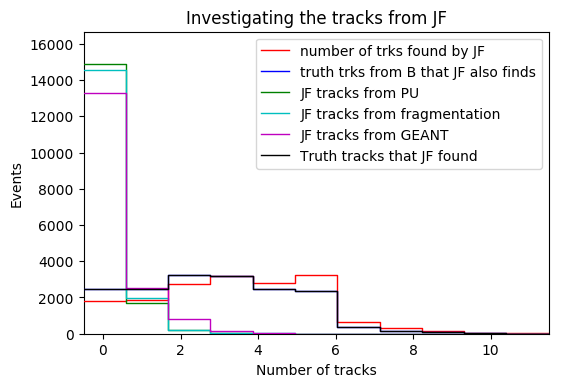

In [10]:
# Draw the histograms
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_ntrks_JF,label='number of trks found by JF', color='r')
rplt.hist(h_ntrks_KEPT, label='truth trks from B that JF also finds',color='b') 
rplt.hist(h_ntrks_PU, label='JF tracks from PU', color='g')
rplt.hist(h_ntrks_FRAG, label='JF tracks from fragmentation', color='c')
rplt.hist(h_ntrks_GEANT, label='JF tracks from GEANT', color='m')
rplt.hist(h_ntrks_KEPT, label='Truth tracks that JF found', color='k')
plt.xlabel('Number of tracks')
plt.ylabel('Events')
plt.legend()
plt.title('Investigating the tracks from JF')
plt.show()

- It seems like GEANT is the most significant fake track, followed by fragmentation
- PU is the least important, because PU is generally along the beam line, and the IP selections should remove most of it.

Conclusion: Most of the tracks that JF finds correspond to truth particles.

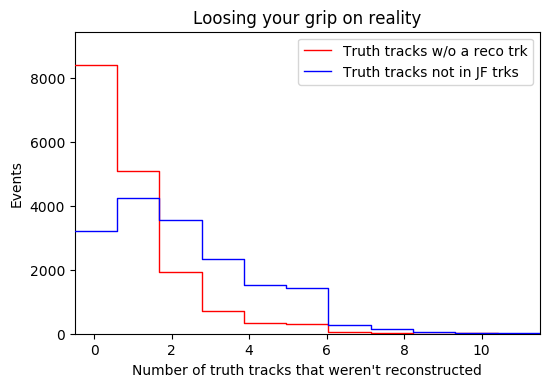

Mean number of truth p'cles lost to reco tracks: 0.884556030389 
Mean number of truth p'cles not found by JF:     2.15432098765 


In [11]:
# Number of truth tracks from B that aren't in reco
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_ntrks_LOST,   label='Truth tracks w/o a reco trk', color='r')
rplt.hist(h_ntrks_LOST_JF,label='Truth tracks not in JF trks', color='b')
plt.xlabel('Number of truth tracks that weren\'t reconstructed')
plt.ylabel('Events')
plt.legend()
plt.title('Loosing your grip on reality')
plt.show()

print "Mean number of truth p'cles lost to reco tracks: {} ".format(h_ntrks_LOST.GetMean())
print "Mean number of truth p'cles not found by JF:     {} ".format(h_ntrks_LOST_JF.GetMean())

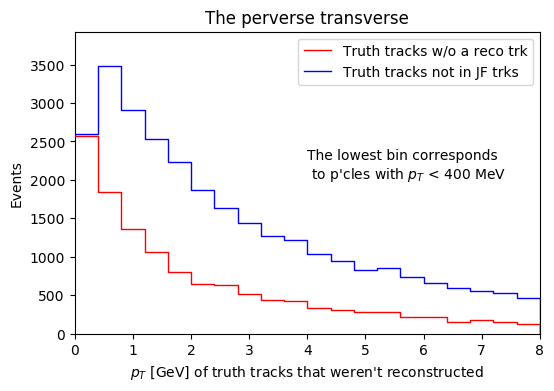

In [12]:
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
ax = fig.add_subplot(111)
rplt.hist(h_LOSTtrks_pT,   label='Truth tracks w/o a reco trk', color='r')
rplt.hist(h_LOSTtrks_pT_JF,label='Truth tracks not in JF trks', color='b')
plt.xlabel('$p_T$ [GeV] of truth tracks that weren\'t reconstructed')
plt.ylabel('Events')
plt.legend()
ax.text(4, 2000, 'The lowest bin corresponds\n to p\'cles with $p_T$ < 400 MeV')
plt.title('The perverse transverse')
plt.show()

There's a pedestal at 400 MeV for truth particles that were reconstructed in reco, which makes sense since we don't have detector resolution that low anyways. I feel like it's kind of wierd / unoptimal that the JF pT dist doesn't peak at the lowest pT bin.

B/c MS

# Calculating a couple numbers

(4) Given all truth particles, how many have tracks?

(5) Given we have a track from a vertex, how many do we miss from JF?

Notes: The truth level info is in BHadronBranches.cxx.

In [13]:
'''
Trying to answer question (4): Given all truth particles, how many have tracks?
I'm going to consider the truth particles from the b-hadron, and just do a pdg match.
So repeat the cell above, but over the whole Ntuple

Also looking at how many jets have lost at least one track, defined from the pdg match?

'''
n_truth = 0
n_trk_pdg_matched = 0
n_trk_barcode_matched = 0

n_jets = 0
n_jetsWithOneLostTrack = 0

for (_,(jet_child_pdg,jet_child_barcode,jet_trk_pdg,jet_trk_barcode)) in df[['jet_bH_child_pdg_id','jet_bH_child_barcode','jet_trk_pdg_id','jet_trk_barcode']].iterrows():
  
    for child_pdgs,child_barcodes,trk_pdgs,trk_barcodes in zip(jet_child_pdg,jet_child_barcode,jet_trk_pdg,jet_trk_barcode):
        # Only continue if this jet had an associated b or c-hadron
        if child_pdgs.size > 0 and child_pdgs[0] != -99:
            
            child_pdgs =  child_pdgs.tolist()
            n_truth = n_truth + len(child_pdgs)
            n_jets = n_jets + 1
            
            for pdg,barcode in zip(trk_pdgs,trk_barcodes):
                if pdg in child_pdgs:
                    n_trk_pdg_matched = n_trk_pdg_matched + 1
                    child_pdgs.remove(pdg)
                if barcode in child_barcodes:
                    n_trk_barcode_matched = n_trk_barcode_matched + 1
            
            if len(child_pdgs) != 0:
                n_jetsWithOneLostTrack = n_jetsWithOneLostTrack +1
            
print "{0} truth particles, {1} pdg matched to reco, {2} barcode matched to reco".format(n_truth,n_trk_pdg_matched,n_trk_barcode_matched)
print "{}% pdg matched".format(100.*n_trk_pdg_matched/n_truth)
print "{}% barcode matched".format(100.*n_trk_barcode_matched/n_truth)

print "\n{0} of the {1} b or c-jets had lost at least one track (defined from the pdg match)".format(n_jetsWithOneLostTrack,n_jets)

82041 truth particles, 74597 pdg matched to reco, 67269 barcode matched to reco
90.9264879755% pdg matched
81.9943686693% barcode matched

4321 of the 16822 b or c-jets had lost at least one track (defined from the pdg match)


The pdg match is not a good measure of the higher efficiency, so it isn't surprising that the efficiency defined this way is higher than the barcode match.

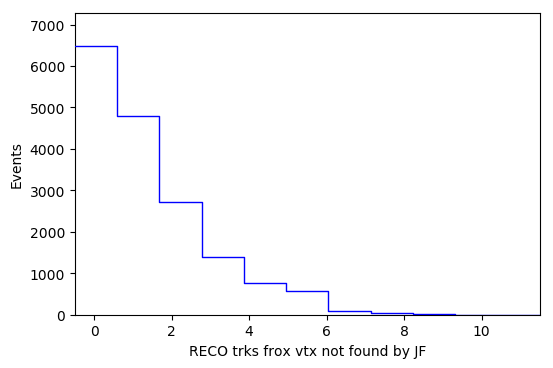

Avg # of tracks lost by JF: 1.27706552707


In [14]:
'''
How many reco tracks associated to the B-cascade by some alg does JF lose?
'''
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_RECOtrks_LOST_JF,color='b')
plt.xlabel('RECO trks frox vtx not found by JF')
plt.ylabel('Events')
plt.show()

print "Avg # of tracks lost by JF: {}".format(h_RECOtrks_LOST_JF.GetMean())

h_ntrks_vs_jpt entries = 16848.0


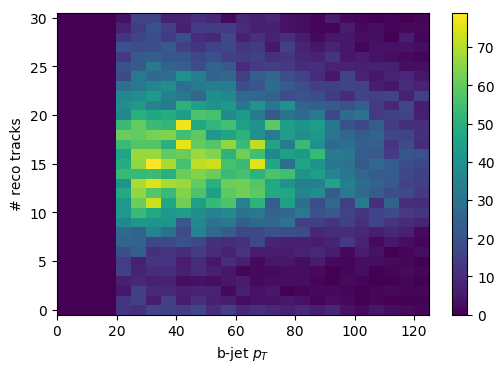

In [15]:
'''
Number of tracks as a function of jet pt 
'''
print "h_ntrks_vs_jpt entries = {}".format(h_ntrks_vs_jpt.GetEntries())
# plot_2D(h_ntrks_vs_jpt,xlabel="b-jet $p_T$ [GeV]",ylabel="Number of reco tracks")

fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist2d(h_ntrks_vs_jpt)#, norm=LogNorm())
im = rplt.imshow(h_ntrks_vs_jpt)
fig.colorbar(im)
plt.xlabel("b-jet $p_T$")
plt.ylabel("# reco tracks")
plt.show()

- All of the jets have a $p_T$ cut of 20 GeV applied.
- In general, there are quite a few reco tracks, almost 3x as many as the expected 5 from the b-cascade
- There doesn't really seem to be a dependence on the # of reco tracks with the jet's pT.